# Deliverable 2

In [114]:
import pandas as pd

dataMBE = pd.read_csv('tmptgbckwct.csv')


dataMBE['street_address'] = dataMBE['address'].str.split(',').str[0]

dataMBE.columns





Index(['company_name', 'services_provided', 'mbe_wbe_cert', 'small_local_cert',
       'veteran_cert', 'sdo_certified', 'city_registered', 'address', 'city',
       'state', 'zipcode', 'contact_name', 'contact_title', 'phone', 'fax',
       'email', 'website', 'business_type', 'construction', 'date_established',
       'number_employees', 'cob_category_codes1', 'cob_category_codes2',
       'cob_category_codes3', 'naics_codes1', 'naics_codes2', 'naics_codes3',
       'unspsc_code1', 'unspsc_code2', 'unspsc_code3', 'street_address'],
      dtype='object')

In [64]:
import geojson
from shapely.geometry import shape, Point
import folium

businessesdf  = pd.read_csv('businesses.csv')

with open("City_Council_Districts_View.geojson") as f:
    gj = geojson.load(f)



businessesdf["NAICS_2017_2digit_desc"] = businessesdf["NAICS_2017_2digit_desc"].astype('category')
businessesdf["Business_Type"] = businessesdf["NAICS_2017_2digit_desc"].cat.codes
businessesdf["Business_Type"].head()

feature = gj['features'][6]
district4 = shape(feature['geometry'])

districtMap = folium.Map(location=[42.333943, -71.130000],zoom_start = 13)
folium.GeoJson(data=district4).add_to(districtMap)
df4 = businessesdf.copy()


district4 = shape(gj['features'][6]['geometry'])
# Filtering data set for district 4 businesses only
df4 = businessesdf[businessesdf.apply(lambda x: Point(x.longitude,x.latitude).within(district4), axis=1)]

df4.head()

,...1,latitude,longitude,business_name,street_address,zip,NAICS_2017_6digit_code,NAICS_2017_6digit_desc,NAICS_2017_2digit_code,NAICS_2017_2digit_desc,estimated_employment,employment_buckets,mainstreet,Business_Type
2667,2668,42.311327,-71.080831,wingz + tingz,388 Blue Hill Ave,2121,722511,Full-Service Restaurants,72,Accommodation and Food Services,5.0,1 to 9,Grove Hall,1
2670,2671,42.305682,-71.081282,washington columbia li,95 Washington St,2121,531210,Offices of Real Estate Agents and Brokers,53,Real Estate Rental and Leasing,3.0,1 to 9,Grove Hall,16
2671,2672,42.305682,-71.081282,washington columbia ii apartments,95 Washington St,2121,0,NaN,99,Undefined,5.0,1 to 9,Grove Hall,19
2672,2673,42.305404,-71.081098,washington columbia ii,102 Columbia Rd,2121,0,NaN,99,Undefined,0.0,Not Available,Grove Hall,19
2674,2675,42.307953,-71.083183,vip wireless,482 Blue Hill Ave,2121,517312,Wireless Telecommunications Carriers (except S...,51,Information,2.0,1 to 9,Grove Hall,9


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


clusterD4Map =  folium.Map(location=[42.305682,-71.081282],zoom_start = 14)
x = np.arange(20)
ys = [i + x + (i*x)**2 for i in range(20)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



for lat,lng,clusters in zip(df4['latitude'], df4['longitude'],  df4['Business_Type']):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        
        color=rainbow[clusters-1],
        fill=True,
        fill_color=rainbow[clusters-1],
        fill_opacity=0.9).add_to(clusterD4Map)


#Map for only district 4 businesses
clusterD4Map

KeyError: 'Business_Type'

In [49]:
import requests
import json

from dotenv import load_dotenv
from os import getenv


load_dotenv()
api_key = getenv("YELP_API_KEY")
headers = {'Authorization': 'Bearer %s' % api_key}


def return_parent_category_yelp(business_name, latitude, longitude, address, row):
    #make a request to yelp_api business/search to get the sub category alias for a business
    business_url = "https://api.yelp.com/v3/businesses/search"
    params = {'locale' : 'en_US', 'term':business_name, 'latitude': latitude, 'longitude':longitude, 'location':address}
    business_search_req = requests.get(business_url, params=params, headers=headers)
    business_search_res = json.loads(business_search_req.text)

    if len(business_search_res["businesses"]) == 0:  #case where business is not on yelp and no results are returned
        return (row["NAICS_2017_2digit_desc"], row["NAICS_2017_2digit_desc"])
    
    #case where the businesiness isn't on yelp but it returns a similar business or there is no associated category available
    if business_search_res["businesses"][0]["location"]["address1"] != address or len(business_search_res["businesses"][0]["categories"]) == 0: 
        return (row["NAICS_2017_2digit_desc"], row["NAICS_2017_2digit_desc"])

    sub_category = business_search_res["businesses"][0]["categories"][0]["alias"]

    #make a request to the categories endpoint to get the parent category
    category_url = "https://api.yelp.com/v3/categories/" + sub_category
    params = {'locale' : 'en_US'}
    category_req = requests.get(category_url, params=params, headers=headers)
    category_res = json.loads(category_req.text)


    if len(category_res["category"]["parent_aliases"]) == 0: #case where there is not parent category associated with the business
        return (row["NAICS_2017_2digit_desc"], row["NAICS_2017_2digit_desc"])


    parent_category = category_res["category"]["parent_aliases"][0]

    return (sub_category, parent_category)

def get_lat_long(address):
    business_url = "https://api.yelp.com/v3/businesses/search"
    params = {'locale' : 'en_US', 'location':address}
    business_search_req = requests.get(business_url, params=params, headers=headers)
    business_search_res = json.loads(business_search_req.text)
    if "error" in business_search_res:
        return (None, None)
        

    if len(business_search_res["businesses"]) == 0:  
        return (None, None)
    
    
    if business_search_res["businesses"][0]["location"]["address1"] != address: 
        return (None, None)

    return (business_search_res["businesses"][0]["coordinates"]["latitude"], business_search_res["businesses"][0]["coordinates"]["longitude"])

In [98]:
# print type of streetaddress column

df4 = df4.dropna(subset=['street_address'])
df4 = df4.reset_index(drop=True)


dataMBE = dataMBE.dropna(subset=['street_address'])
dataMBE = dataMBE.reset_index(drop=True)


#  new column for df4 that contains the street name without the number
df4["street_name"] =  df4.apply(lambda x: " ".join(x["street_address"].split(" ")[1:]), axis=1)

# new column for dataMBE that contains the street name without the number
dataMBE["street_name"] = dataMBE.apply(lambda x: " ".join(x["street_address"].split(" ")[1:]), axis=1)

# find the intersection of the two dataframes
intersection = df4.merge(dataMBE, on="street_name", how="inner")

intersection.head(6)



,...1,latitude_x,longitude_x,business_name,street_address_x,zip,NAICS_2017_6digit_code,NAICS_2017_6digit_desc,NAICS_2017_2digit_code,NAICS_2017_2digit_desc,...,cob_category_codes3,naics_codes1,naics_codes2,naics_codes3,unspsc_code1,unspsc_code2,unspsc_code3,street_address_y,latitude_y,longitude_y
0,2692,42.308200,-71.082800,stone & skillet,198 Quincy St,2121,311812,Commercial Bakeries,31,Manufacturing,...,MU - Manufacturers,722330 - Mobile Food Services,722320 - Caterers,312111 - Soft Drink Manufacturing,73130000 - Food and beverage industries,90100000 - Restaurants and catering,50190000 - Prepared and preserved foods,196 Quincy St,None,None
1,3563,42.285820,-71.064728,yankee insurance agency,569 Talbot Ave,2124,524210,Insurance Agencies and Brokerages,52,Finance and Insurance,...,NaN,"811121 - Automotive Body, Paint, and Interior ...",811192 - Car Washes,811118 - Other Automotive Mechanical and Elect...,25100000 - Motor vehicles,NaN,NaN,10 Talbot Ave,None,None
2,3611,42.286152,-71.064884,micci fuel co,551 Talbot Ave,2124,238220,"Plumbing, Heating, and Air-Conditioning Contra...",23,Construction,...,NaN,"811121 - Automotive Body, Paint, and Interior ...",811192 - Car Washes,811118 - Other Automotive Mechanical and Elect...,25100000 - Motor vehicles,NaN,NaN,10 Talbot Ave,None,None
3,3612,42.285804,-71.064730,metro by t-mobile-authorized retailer,573 Talbot Ave,2124,517312,Wireless Telecommunications Carriers (except S...,51,Information,...,NaN,"811121 - Automotive Body, Paint, and Interior ...",811192 - Car Washes,811118 - Other Automotive Mechanical and Elect...,25100000 - Motor vehicles,NaN,NaN,10 Talbot Ave,None,None
4,3684,42.285804,-71.064730,asian gallery art & gift shop,571 Talbot Ave,2124,453220,"Gift, Novelty, and Souvenir Stores",45,Retail Trade,...,NaN,"811121 - Automotive Body, Paint, and Interior ...",811192 - Car Washes,811118 - Other Automotive Mechanical and Elect...,25100000 - Motor vehicles,NaN,NaN,10 Talbot Ave,None,None
5,3687,42.285999,-71.064815,ashmont grill,555 Talbot Ave,2124,722310,Food Service Contractors,72,Accommodation and Food Services,...,NaN,"811121 - Automotive Body, Paint, and Interior ...",811192 - Car Washes,811118 - Other Automotive Mechanical and Elect...,25100000 - Motor vehicles,NaN,NaN,10 Talbot Ave,None,None


# DO NOT RUN THE API CALLS AGAIN. THEY ARE SLOW AND WILL TAKE A LONG TIME TO RUN. THE OUTPUT IS ALREADY IN THE NOTEBOOK.

In [ ]:
# How many rows are not located in boston from dataMBE


In [ ]:

dataMBE["latitude"] = None
dataMBE["longitude"] = None

for index, row in dataMBE.iterrows():
    lat, long = get_lat_long(row["address"])
    dataMBE.at[index, "latitude"] = lat
    dataMBE.at[index, "longitude"] = long





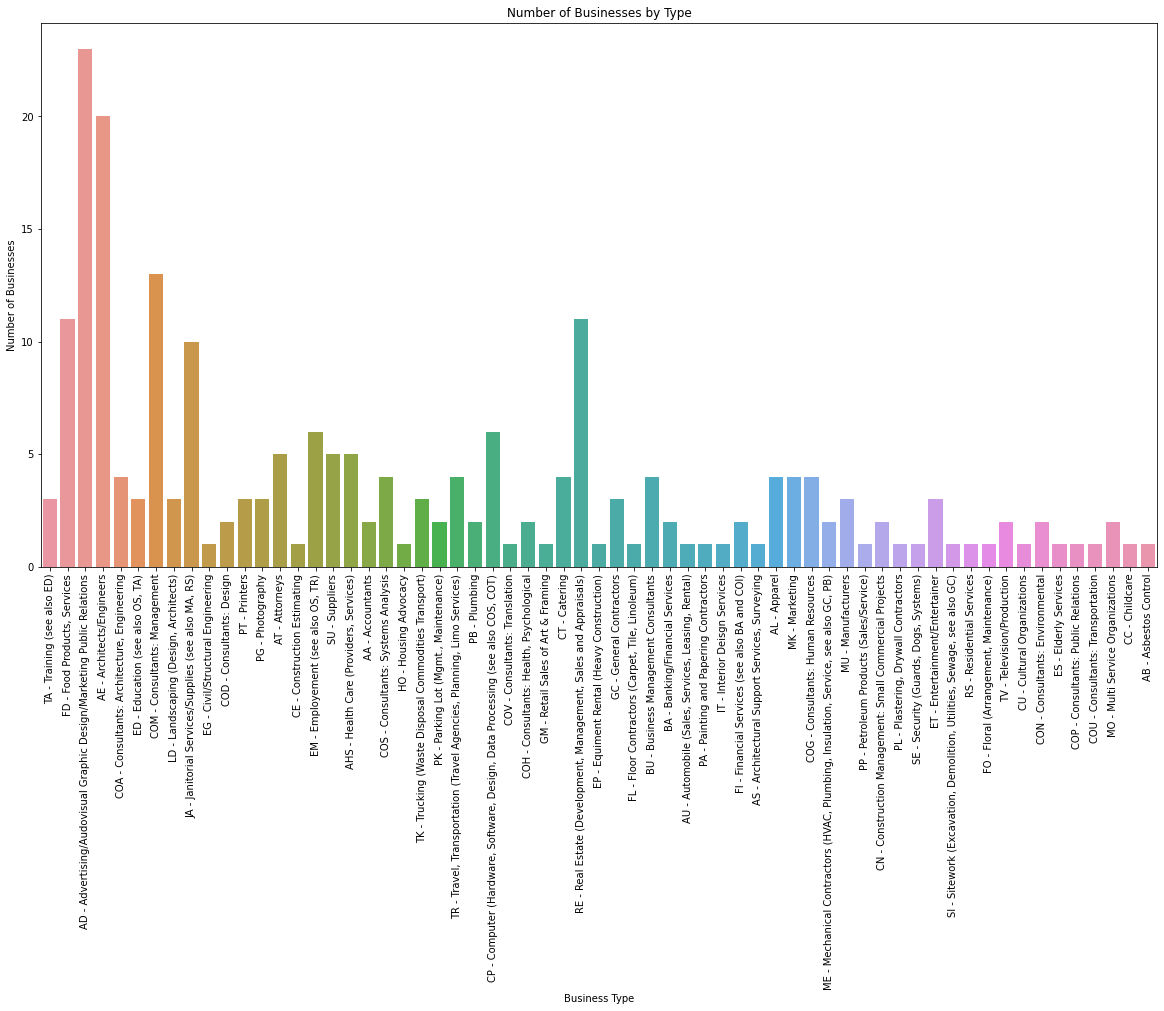

(223, 34)

In [110]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# graph of different types of businesses dataMBA
plt.figure(figsize=(20,10))
sns.countplot(x="cob_category_codes1", data=dataMBE)
plt.title("Number of Businesses by Type")
plt.xticks(rotation=90)
plt.xlabel("Business Type")
plt.ylabel("Number of Businesses")
plt.show()

dataMBE.shape






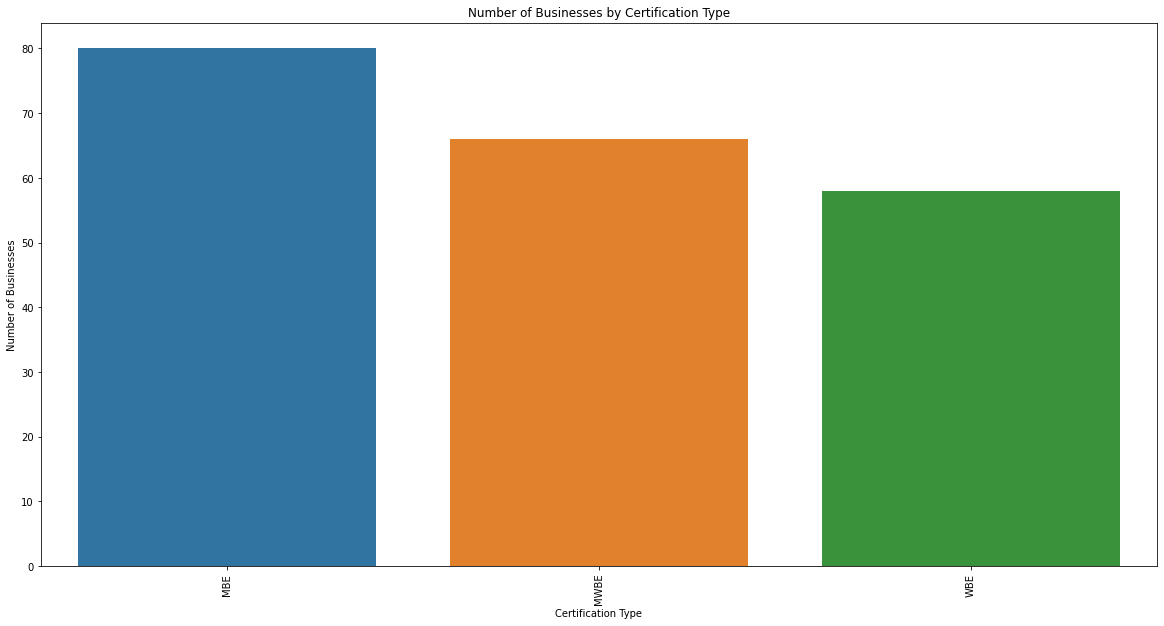

In [112]:
# plot mbe wbe cert types for dataMBE
plt.figure(figsize=(20,10))
sns.countplot(x="mbe_wbe_cert", data=dataMBE)
plt.title("Number of Businesses by Certification Type")
plt.xticks(rotation=90)
plt.xlabel("Certification Type")
plt.ylabel("Number of Businesses")
plt.show()



In [113]:
# boston district 4 zipcodes list
zipcodes = ["02108", "02109", "02110", "02111", "02112", "02113", "02114", "02115", "02116", "02117", "02118", "02119", "02120", "02121", "02122", "02123", "02124", "02125", "02126", "02127", "02128", "02129", "02130", "02131", "02132", "02133", "02134", "02135", "02136", "02137", "02163", "02199"]

,...1,latitude_x,longitude_x,business_name,street_address_x,zip,NAICS_2017_6digit_code,NAICS_2017_6digit_desc,NAICS_2017_2digit_code,NAICS_2017_2digit_desc,...,naics_codes1,naics_codes2,naics_codes3,unspsc_code1,unspsc_code2,unspsc_code3,street_address_y,street_name_y,latitude_y,longitude_y
